### Log Anomlay Detector Core Mininimal Implementation

In an effort to help new users and contributors understand the core Machine Learning elements of the log anomaly detector I have decided to recreate a streamlined minimal version. Here we will ignore any streaming or external aspect of our data and use a fixed local data file for simplicity and reproducability.   

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomlay Scores
* Model Inference /Prediction

For the most part function names have been made to match their relevent counter part in the larger code base.

My aim for this notebook is that, by the end a reader will 1) have a clear understanding of how the current implementation works and 2) know where to make changes to try another approach. 

### Import our packages

In [14]:
import os
import time
import numpy as np
import logging
import sompy
from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt


### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [15]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [16]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [17]:
def train(inp, map_size, iterations, parallelism):
    print(f'training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [18]:
def get_anomaly_score(logs, parallelism, model):

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters):
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [19]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocesses. Here was can see this is a rather small example, with 10,000 log lines, but only 3 unique log messages

In [20]:
data_path = r"/Users/Martu/Downloads/log-anomaly-detector-master/validation_data/log_anomaly_detector-10000-events.json"

In [21]:
data = pd.read_json(data_path)

In [22]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [23]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [24]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

DEBUGProcessedoutofpackages 9786
ThreadodcsserverINFOComposetypestatedoneComposedone 213
rootCMDusrlocalbinmonitorapachestatsshdevnull 1


In [25]:
data

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages
5,DEBUGProcessedoutofpackages
6,DEBUGProcessedoutofpackages
7,DEBUGProcessedoutofpackages
8,DEBUGProcessedoutofpackages
9,DEBUGProcessedoutofpackages


#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with thier vectorized representation. 

In [26]:
w2vmodel = create(data, 100,3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
effective_min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 100 dimensions: 3900 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 99850 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 35 : training on 10000 raw words (366 effective words) took 0.0s, 148630 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 36 : training on 10000 raw words (354 effective words) took 0.0s, 131236 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 37 : training on 10000 raw words (381 effective words) took 0.0s, 160713 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 38 : training on 10000 raw words (378 effective words) took 0.0s, 107649 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 72 : training on 10000 raw words (376 effective words) took 0.0s, 99432 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 73 : training on 10000 raw words (395 effective words) took 0.0s, 114714 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 74 : training on 10000 raw words (349 effective words) took 0.0s, 150097 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 75 : training on 10000 raw words (381 effective words) took 0.0s, 99978 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 76 : training on 10

worker thread finished; awaiting finish of 0 more threads
EPOCH - 109 : training on 10000 raw words (354 effective words) took 0.0s, 185781 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 110 : training on 10000 raw words (403 effective words) took 0.0s, 114152 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 111 : training on 10000 raw words (384 effective words) took 0.0s, 99845 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 112 : training on 10000 raw words (365 effective words) took 0.0s, 140097 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 113 : training on 10000 raw words (400 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 146 : training on 10000 raw words (372 effective words) took 0.0s, 127349 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 147 : training on 10000 raw words (401 effective words) took 0.0s, 107433 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 148 : training on 10000 raw words (364 effective words) took 0.0s, 133655 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 149 : training on 10000 raw words (361 effective words) took 0.0s, 154504 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 150 : training on 10000 raw words (400 effecti

worker thread finished; awaiting finish of 0 more threads
EPOCH - 183 : training on 10000 raw words (399 effective words) took 0.0s, 112263 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 184 : training on 10000 raw words (378 effective words) took 0.0s, 82793 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 185 : training on 10000 raw words (383 effective words) took 0.0s, 85530 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 186 : training on 10000 raw words (416 effective words) took 0.0s, 107830 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 187 : training on 10000 raw words (373 effective

EPOCH - 220 : training on 10000 raw words (356 effective words) took 0.0s, 65635 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 221 : training on 10000 raw words (394 effective words) took 0.0s, 165903 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 222 : training on 10000 raw words (386 effective words) took 0.0s, 86160 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 223 : training on 10000 raw words (407 effective words) took 0.0s, 160882 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 224 : training on 10000 raw words (355 effective words) took 0.0s, 93784 effective words/s
job loop exitin

EPOCH - 257 : training on 10000 raw words (391 effective words) took 0.0s, 164312 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10000 raw words (378 effective words) took 0.0s, 90902 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10000 raw words (371 effective words) took 0.0s, 102415 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10000 raw words (370 effective words) took 0.0s, 81475 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10000 raw words (396 effective words) took 0.0s, 154349 effective words/s
job loop exiti

EPOCH - 294 : training on 10000 raw words (397 effective words) took 0.0s, 86567 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 295 : training on 10000 raw words (374 effective words) took 0.0s, 160014 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 296 : training on 10000 raw words (380 effective words) took 0.0s, 89878 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 297 : training on 10000 raw words (382 effective words) took 0.0s, 136374 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 298 : training on 10000 raw words (383 effective words) took 0.0s, 147075 effective words/s
job loop exiti

EPOCH - 331 : training on 10000 raw words (375 effective words) took 0.0s, 182474 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 332 : training on 10000 raw words (393 effective words) took 0.0s, 172032 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 333 : training on 10000 raw words (370 effective words) took 0.0s, 75076 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 334 : training on 10000 raw words (389 effective words) took 0.0s, 144551 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 335 : training on 10000 raw words (412 effective words) took 0.0s, 113246 effective words/s
job loop exit

EPOCH - 368 : training on 10000 raw words (384 effective words) took 0.0s, 154792 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10000 raw words (382 effective words) took 0.0s, 141566 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10000 raw words (348 effective words) took 0.0s, 89165 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 371 : training on 10000 raw words (353 effective words) took 0.0s, 84467 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 372 : training on 10000 raw words (393 effective words) took 0.0s, 152867 effective words/s
job loop exiti

EPOCH - 405 : training on 10000 raw words (349 effective words) took 0.0s, 91095 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 406 : training on 10000 raw words (414 effective words) took 0.0s, 107607 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 407 : training on 10000 raw words (372 effective words) took 0.0s, 94113 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 408 : training on 10000 raw words (383 effective words) took 0.0s, 188143 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 409 : training on 10000 raw words (379 effective words) took 0.0s, 90571 effective words/s
job loop exitin

EPOCH - 442 : training on 10000 raw words (388 effective words) took 0.0s, 97227 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 443 : training on 10000 raw words (395 effective words) took 0.0s, 109325 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 444 : training on 10000 raw words (344 effective words) took 0.0s, 82202 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 445 : training on 10000 raw words (378 effective words) took 0.0s, 97215 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 446 : training on 10000 raw words (396 effective words) took 0.0s, 104025 effective words/s
job loop exitin

EPOCH - 479 : training on 10000 raw words (354 effective words) took 0.0s, 135969 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 480 : training on 10000 raw words (413 effective words) took 0.0s, 161951 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 481 : training on 10000 raw words (371 effective words) took 0.0s, 81304 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 482 : training on 10000 raw words (370 effective words) took 0.0s, 86538 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 483 : training on 10000 raw words (387 effective words) took 0.0s, 144459 effective words/s
job loop exiti

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 517 : training on 10000 raw words (397 effective words) took 0.0s, 76808 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10000 raw words (397 effective words) took 0.0s, 170115 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10000 raw words (381 effective words) took 0.0s, 103032 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10000 raw words (351 effective words) took 0.0s, 87529 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more 

In [27]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a few vizualiztions of the trained model

In [26]:
# map_size = 16
# model = train(transformed_data, map_size, 0, 2)

/Users/Martu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/Martu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/Martu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/Martu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/Martu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_mea

[-24726.95637574806, -1.8501424771033896, -0.0, -0.0, -0.0, -0.0, -0.0, -3.552713678800501e-15, -3.552713678800501e-15]


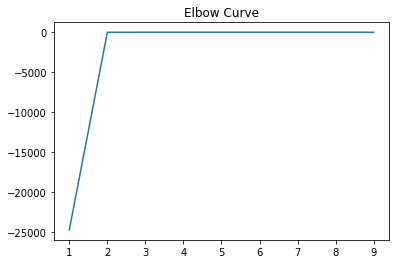

In [29]:
# First implementation for K-means with sklearn 
# (using Euclidean distance without normalization)
from sklearn.cluster import KMeans;
import matplotlib.pyplot as pl
n = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in n]
kmeans
score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
print(score)
pl.plot(n,score)
pl.title('Elbow Curve')
pl.show()

In [30]:
n_cluster = 2
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', n_init= 20, max_iter=300, n_jobs = None, algorithm="auto")

#cluster index vector
index = kmeans.fit_predict(transformed_data)
print(index)

# Distance matrix
dist = kmeans.fit_transform(transformed_data)
print(dist)

np.unique(kmeans.labels_)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in kmeans.labels_)
# number of 0: 9787
sum(i == 0 for i in kmeans.labels_)

[0 0 0 ... 0 0 0]
[[1.38987335e-04 1.08907978e+01]
 [1.38987335e-04 1.08907978e+01]
 [1.38987335e-04 1.08907978e+01]
 ...
 [1.38987335e-04 1.08907978e+01]
 [1.38987335e-04 1.08907978e+01]
 [1.38987296e-04 1.08907978e+01]]


9787

In [31]:
# Second implementation for K-means with sklearn
# (Using Cosine similarity)
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(n_cluster, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters= True)
labels = kclusterer.cluster(transformed_data, assign_clusters=True)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in labels)
# number of 0: 9787
sum(i == 0 for i in labels)

9787

C:\Users\martu\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\martu\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\martu\Anaconda3\lib\site-packages\sompy\visualization\hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


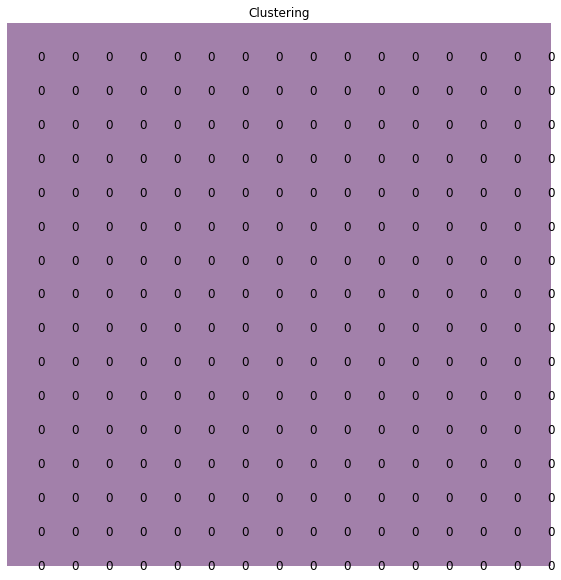

In [20]:
# from sompy.visualization.hitmap import HitMapView
# model.cluster(3)
# hits  = HitMapView(10,10,"Clustering",text_size=7)
# a=hits.show(model, labelsize=12)

In [ ]:
# from sompy.visualization.mapview import View2D
# view2D  = View2D(10,10,"rand data",text_size=10)
# view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

In [ ]:
# from sompy.visualization.bmuhits import BmuHitsView

# vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
# vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [15]:
 m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [22]:
%qtconsole

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [ ]:
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

In [1]:
plt.hist(distances)
plt.show()

NameError: name 'plt' is not defined

In [2]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

NameError: name 'np' is not defined

In [3]:
threshold

NameError: name 'threshold' is not defined

In [4]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

NameError: name 'distances' is not defined

In [5]:
data.message.value_counts()

NameError: name 'data' is not defined

#### Test 

In [ ]:
infer(,m,'rootCMDusrlocalbinmonitorapachestatsshdevnull', data,threshold)

In [ ]:
infer(w2vmodel,m,'DEBUGProcessedoutofpackages', data,threshold)

In [ ]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

In [ ]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

In [ ]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

In [ ]:
infer(w2vmodel,m,'message',data,threshold)